In [1]:
import numpy as np
from matplotlib import pyplot as plt

def solve_laplace_equation(A, BC, idx, tolerance=1e-3, max_iter=1000):
    '''
    This function solves the Laplace equation
    Input:
    A: Parameter array, for example head or flow
    BC: Boundary conditions array
    idx: Index at the middle x of the grid
    tolerance: Tolerance for the solution, by default 1e-3
    max_iter: Maximum number of iterations, by default 1000 

    Note:
    The function modifies the A array in place
    '''
    # initialize difference and counter
    difference = 1.0
    counter = 0
    # hold the old values of A
    A_old = A.copy()
    while difference > tolerance or counter < max_iter:
        # the problem is symmetric, 
        # so we solve only for the left half of the grid
        for i in range(A.shape[0]):
            for j in range(idx+1):
                if BC[i, j] == 0:
                    # solve the laplace equation using finite differences
                    # Eq. 11.23 of Budhu (2007), Soil Mechanics and Foundations
                    # left node
                    if j == 0:
                        left_nod = A[i, j+1]
                    else:
                        left_nod = A[i, j-1]
                    # right node
                    if j == idx:
                        right_nod = A[i, j-1]
                    else:
                        right_nod = A[i, j+1]
                    # top node
                    if i == 0:
                        top_nod = A[i+1, j]
                    else:
                        top_nod = A[i-1, j]
                    # bottom node
                    if i == A.shape[0]-1:
                        bottom_nod = A[i-1, j]
                    else:
                        bottom_nod = A[i+1, j]
                    A[i, j] = (left_nod + right_nod + top_nod + bottom_nod) / 4.0
        # update the difference, old values, and counter
        difference = np.max(np.abs(A - A_old))
        A_old = A.copy()
        counter += 1
    
    # add values to the right half of the grid
    A[:, idx+1:] = np.flip(A[:, :idx], axis=1)

def flow_net(H1, H2, H3, D, cell_size, Nd_up, Nf, grid_on=False):
    '''
    This function draws the flow net for the case
    of a sheet pile wall, horizontal layers, and
    a permeable layer over an impermeable base.

    Input:
    H1: Height of water column in upstream side of wall
    H2: Height of water column in downstream side of wall
    H3: Depth of wall penetration in the permeable layer
    D: Thickness of the permeable layer
    cell_size: Size of the cells in the flow net
    Nd_up: Number of equipotential falls in upstream side of wall
    Nf: Number of flow channels
    grid_on: Boolean to show the grid, by default False

    Notes: 
    H1 must be greater than H2
    H3 must be less than D
    '''
    # width of the flow net
    width = D * 4
    # head difference
    delta_H = H1 - H2
    # x-coordinates of the flow net
    x = np.arange(0, width+cell_size, cell_size)
    # y-coordinates of the flow net
    y = np.arange(0, D+cell_size, cell_size)
    # create the grid
    X, Y = np.meshgrid(x, y)
    
    # Boundary conditions array 
    BC = np.zeros((y.size, x.size))
    # Head array
    H = np.zeros((y.size, x.size))
    # Flow array
    Q = np.zeros((y.size, x.size))
    # find the index in x at width/2
    idx = np.where(x == width/2.0)[0][0]
    # find the index in y at H3
    idy = np.where(y == H3)[0][0]
    
    # Calculate the head values
    # Boundary conditions
    # top nodes
    BC[0, :] = 1
    H[0, :] = delta_H
    # middle nodes below the wall
    BC[idy:, idx] = 1
    H[idy:, idx] = delta_H/2.0
    # solve for the head values
    solve_laplace_equation(H, BC, idx)

    # Calculate the flow values
    # Eq. 11.32 of Budhu (2007), Soil Mechanics and Foundations
    q = (H[1,0]-H[3,0]+H[1,idx]-H[3,idx]+2.0*np.sum(H[1,1:idx])-2.0*np.sum(H[3,1:idx]))/4.0
    # reset BC to zero
    BC = np.zeros((y.size, x.size))
    # Boundary conditions
    # left nodes
    BC[:, 0] = 1
    Q[:, 0] = q
    # bottom nodes
    BC[-1, :] = 1
    Q[-1, :] = q
    # wall nodes
    BC[:idy+1, idx] = 1
    Q[:idy+1, idx] = 0.0
    # solve for the flow values
    solve_laplace_equation(Q, BC, idx)
    
    # figure
    fig, ax = plt.subplots(figsize=(10, 5))
    # equal axes
    ax.set_aspect('equal')
    # y-axis in the downward direction
    ax.invert_yaxis()
    # remove axes
    ax.axis('off')
    
    # draw the water upstream
    ax.plot([0, width/2.0], [-H1, -H1], 'b')
    ax.fill_between([0, width/2.0], -H1, 0.0, color='b', alpha=0.5)
    # draw the water downstream
    ax.plot([width/2.0, width], [-H2, -H2], 'b')
    ax.fill_between([width/2.0, width], -H2, 0.0, color='b', alpha=0.5)
    
    # draw the impermeable layer
    ax.fill_between([0, width], 0, D, color='y', alpha=0.5)
    
    # draw the grid
    if grid_on:
        for i in range(X.shape[0]):
            ax.plot(X[i, :], Y[i, :], 'lightgray')
        for i in range(Y.shape[1]):
            ax.plot(X[:, i], Y[:, i], 'lightgray')

    # draw the equipotential lines: contours of H
    c_levels = np.linspace(delta_H/2.0, delta_H, int(Nd_up)+1)
    ax.contour(X, Y, H, c_levels, colors='green')
    # draw the flow channels: contours of Q
    c_levels = np.linspace(0, q, int(Nf)+1)
    ax.contour(X, Y, Q, c_levels, colors='red')

    # draw the wall
    ax.plot([width/2.0, width/2.0], [-1.25*H1, H3], 'k', lw=2)

    # draw scale bar
    ax.plot([0.0, D/2.0], [1.25*D, 1.25*D], 'k', lw=2)
    ax.text(D/4.0, 1.2*D, f'{D/2:.0f} m', ha='center', va='center')

    plt.show()

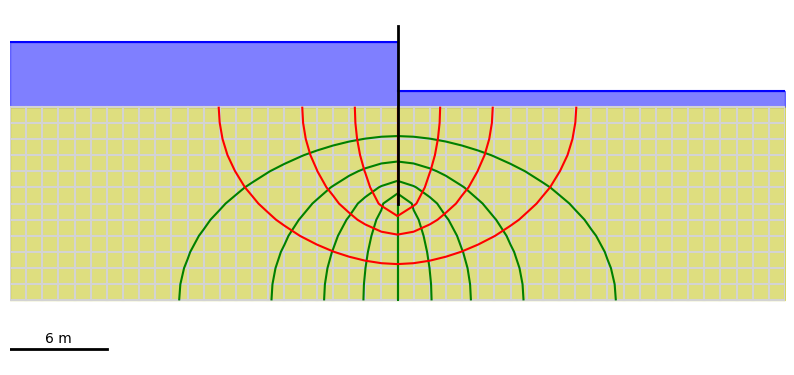

In [2]:
# Example
H1 = 4 # water column height upstream
H2 = 1 # water column height downstream
H3 = 6 # depth of wall penetration
D = 12 # thickness of the permeable layer
cell_size = 1 # size of the cells
Nd_up = 5 # number of equipotential lines upstream
Nf = 4 # number of flow channels

# show the flow net
flow_net(H1, H2, H3, D, cell_size, Nd_up, Nf, grid_on=True)